# Programming Assignment 2: Random Forests

**Members:** Michael Hoon Yong Hau (yongm@chalmers.se), Chua Shan Hong (shanho@chalmers.se)

**PA2 Group 5**

## Task 1: Working with a dataset with categorical features

We will start by reading the train and test files via Pandas, and splitting the data into the input part `X` and an output part `Y`.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("adult_train.csv")
test = pd.read_csv("adult_test.csv")

# Shuffle the dataset.
train_shuffled = train.sample(frac=1.0, random_state=69)
test_shuffled = test.sample(frac=1.0, random_state=69)

# Split into input part X and output part Y.
Xtrain = train_shuffled.drop('target', axis=1)
Xtest = test_shuffled.drop('target', axis=1)

# Map the target income variable to binary value
def to_label(y):
    return 1 if y == ">50K" else 0

Ytrain = train_shuffled['target'].apply(to_label)

Ytest = test_shuffled['target'].apply(to_label)

Xtrain.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
20513,63,?,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,15,United-States
11946,22,Private,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,27,United-States
1703,30,Self-emp-inc,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,60,United-States
12761,28,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
19071,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States


## Numerical Feature Encoding

We will be using one-hot encoding of the categorical features in the dataset as mentioned, with `scikit-learn`.

In [2]:
from sklearn.feature_extraction import DictVectorizer

# convert the training DataFrame into a list of dictionaries:
dicts_Xtrain = Xtrain.to_dict(orient='records')

# make and apply the DictVectorizer
dv = DictVectorizer()

# encode numerical representation of the data
Xtrain_encoded = dv.fit_transform(dicts_Xtrain)

# repeat for test set
dicts_Xtest = Xtest.to_dict(orient='records')

Xtest_encoded = dv.transform(dicts_Xtest)

Xtrain_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 423293 stored elements and shape (32561, 107)>

Now that we have a numerical representation of the data, we can compute a cross-validation accuracy for the training set using one of the classifiers in the previous assignment. For the purpose of this task, we will be using the Gradient Boosting Classifier as it had the highest accuracy score, and is rather robust.

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=69)
gb.fit(Xtrain_encoded, Ytrain)

GradientBoostingClassifier(random_state=69)

We will now compute an aggregated (*mean*) cross-validation accuracy for the training set using the Gradient Boosting Model with 5 folds, similar to the previous assignment.

In [4]:
from sklearn.model_selection import cross_validate

np.mean(cross_validate(gb, Xtrain_encoded, Ytrain, cv=5)['test_score'])

np.float64(0.8651145403390913)

From above, we see that the Gradient Boosting Classifier achieved a mean cross validation accuracy of **~86.5%**.

### Pipeline Creation

Keeping track of the preprocessing steps can be tedious and error-prone, so it makes sense to handle such preprocessing chains automatically. Here, we build a pipeline using the scikit-learn `make_pipeline` function.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# make pipeline

gb_pipeline = make_pipeline(
    DictVectorizer(),
    GradientBoostingClassifier(random_state=69)
)

# fitting the pipeline on encoded training data

gb_pipeline.fit(dicts_Xtrain, Ytrain)

Y_pred = gb_pipeline.predict(dicts_Xtest)

# evaluate pipeline accuracy score

accuracy_score(Ytest, Y_pred)

0.8711381364781033

We see that the pipeline created above works, and achieved a test accuracy score of **~87.1%**.

# Task 2: Decision trees and random forests

## Underfitting and overfitting in decision tree classifiers

Previously, we investigated the performance of a regression model as a function of the depth of the decision trees. Below, we will reproduce the previous experiment from PA1 for this adult dataset, but now using scikit-learn's `DecisionTreeClassifier` instead of the manually created classifier model.

To evaluate the performance of the `DecisionTreeClassifier` as a function of the depth of the decision trees, we need to take note of the `max_depth` parameter. First, we compute the accuracy scores for the different `max_depth`s in the `DecisionTreeClassifier`. We will be using the gini impurity criterion.

In [6]:
from sklearn.tree import DecisionTreeClassifier

def dtc_accuracy(depth_range):
    train_acc = []
    test_acc = []

    for depth in range(1, depth_range):
        dt = DecisionTreeClassifier(max_depth=depth, random_state=69, criterion='gini')
        dt.fit(Xtrain_encoded, Ytrain)
        train_acc.append(dt.score(Xtrain_encoded, Ytrain))
        test_acc.append(dt.score(Xtest_encoded, Ytest))

    return train_acc, test_acc


depth_range = 31
train_acc, test_acc = dtc_accuracy(depth_range)

### Accuracy Score

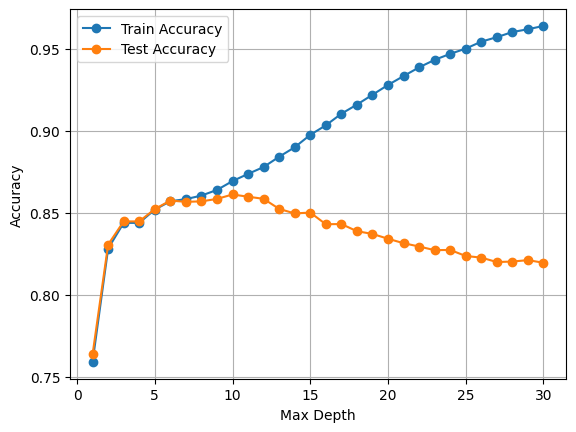

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(1, depth_range), train_acc, label='Train Accuracy', marker='o')
plt.plot(range(1, depth_range), test_acc, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

From the figure above, we can clearly see that the model starts to overfit at around a `max_depth` of 10 for the `DecisionTreeClassifier`, with an exponentially widening generalisation gap past the `max_depth` of 10. This is a similar effect compared to the regression task in the previous assignment.

## Underfitting and overfitting in random forest classifiers.

Now we replace the `DecisionTreeClassifier` with a `RandomForestClassifier`.

The hyperparameter `n_estimators` defines the number of decision trees used in ensemble. We want to investigate how the underfitting/overfitting curve is affected by the number of trees.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from time import perf_counter

def rfc_accuracy(depth_range, n_estimators):
    train_acc = []
    test_acc = []
    train_time = []

    for depth in range(1, depth_range):
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimators, random_state=69, n_jobs=-1)
        start_time = perf_counter()
        rf.fit(Xtrain_encoded, Ytrain)
        end_time = perf_counter()
        train_acc.append(rf.score(Xtrain_encoded, Ytrain))
        test_acc.append(rf.score(Xtest_encoded, Ytest))
        train_time.append(end_time - start_time)

    return train_acc, test_acc, train_time

depth_range = 31
ensemble_sizes = [1, 10, 20, 50, 100, 200]
train_acc_list = []
test_acc_list = []
train_time_list = []

for n_estimators in ensemble_sizes:
    train_acc, test_acc, train_time = rfc_accuracy(depth_range, n_estimators)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_time_list.append(train_time)

### Accuracy Score

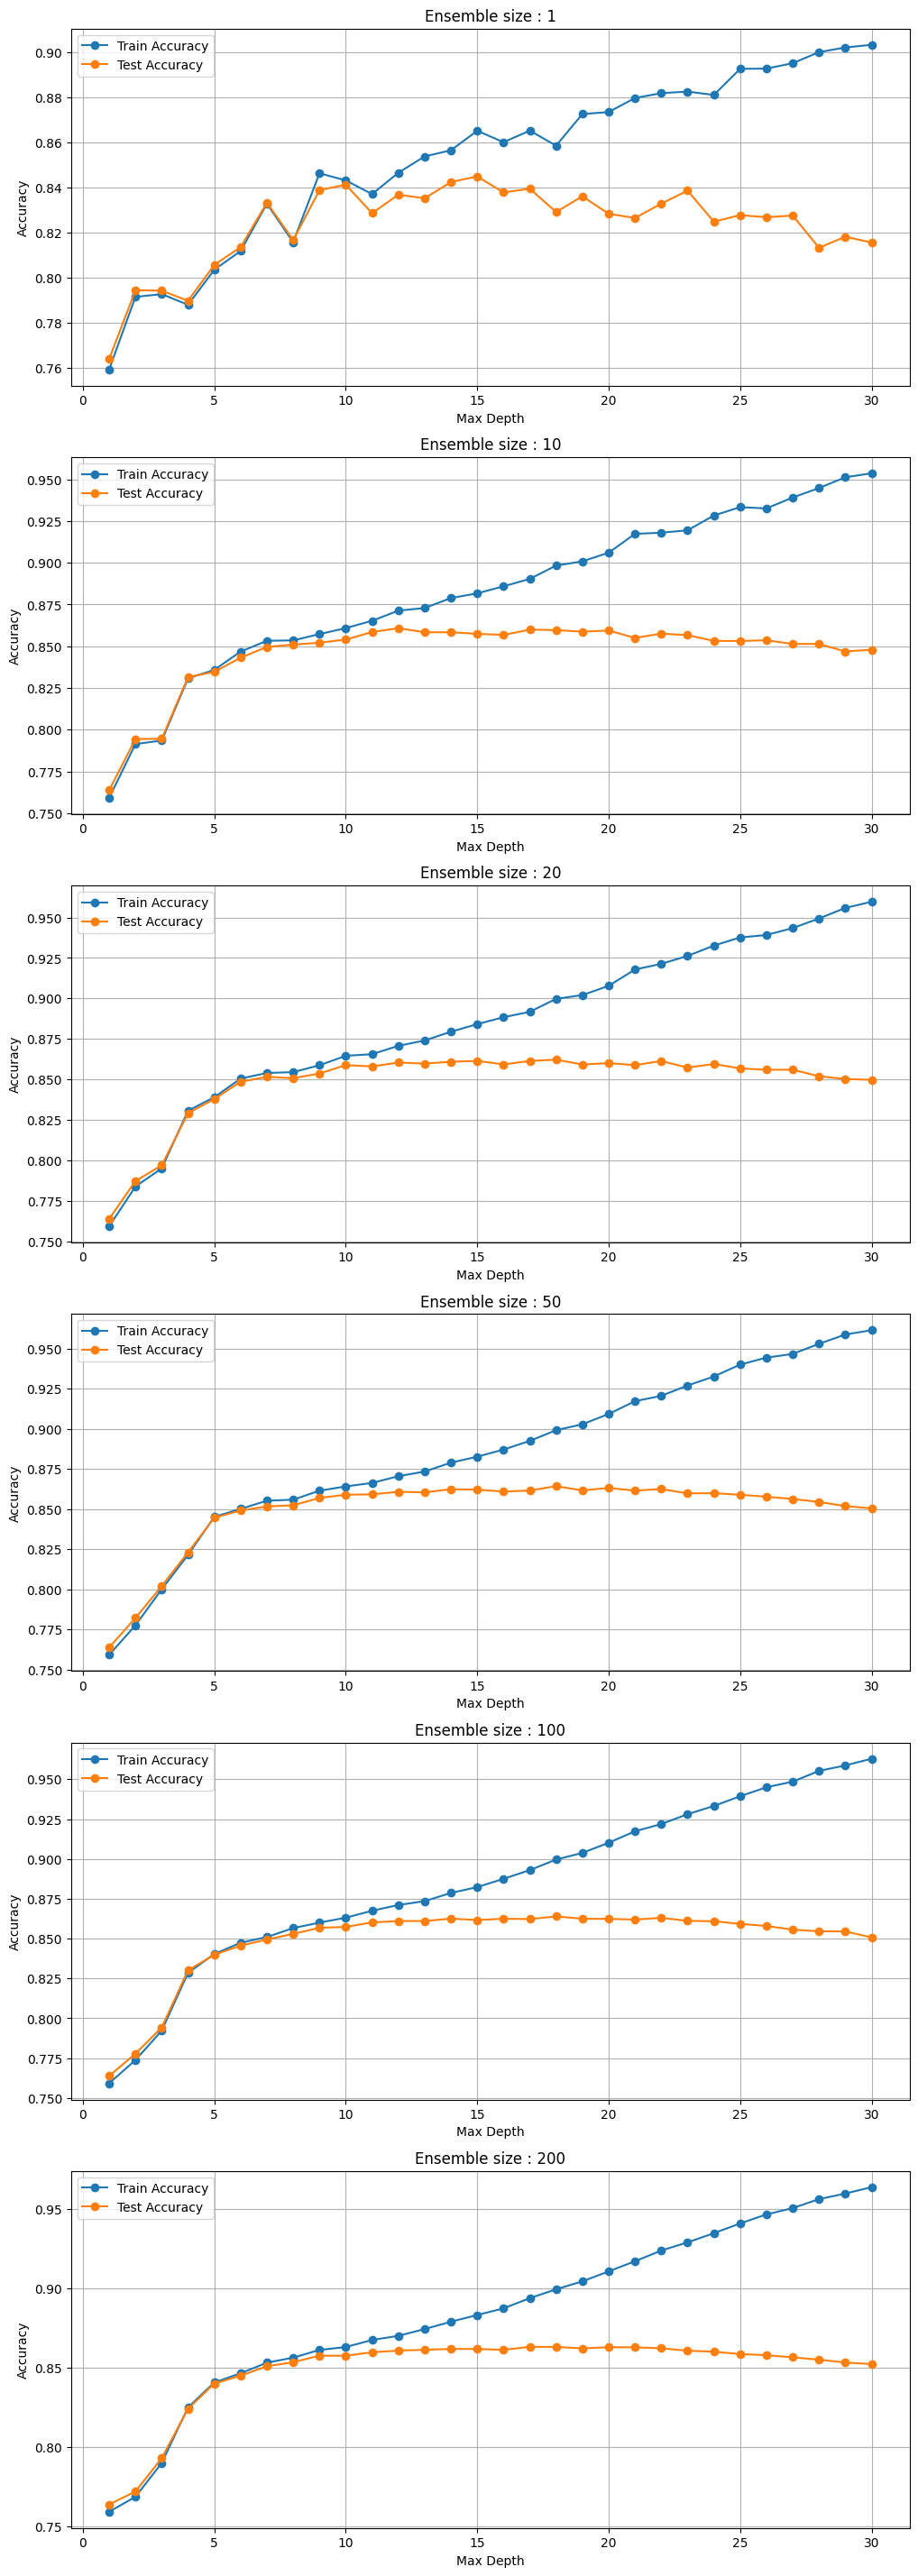

In [9]:
fig, ax = plt.subplots(len(ensemble_sizes), 1, figsize = (12, 6 * len(ensemble_sizes)))

for i, size in enumerate(ensemble_sizes):
    ax[i].plot(range(1, depth_range), train_acc_list[i], label='Train Accuracy', marker='o')
    ax[i].plot(range(1, depth_range), test_acc_list[i], label='Test Accuracy', marker='o')
    ax[i].set_title(f"Ensemble size : {size}")
    ax[i].set_xlabel('Max Depth')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()
    ax[i].grid(True)

plt.show()

### Max Test Set Accuracy

/tmp/ipykernel_7681/2271056814.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


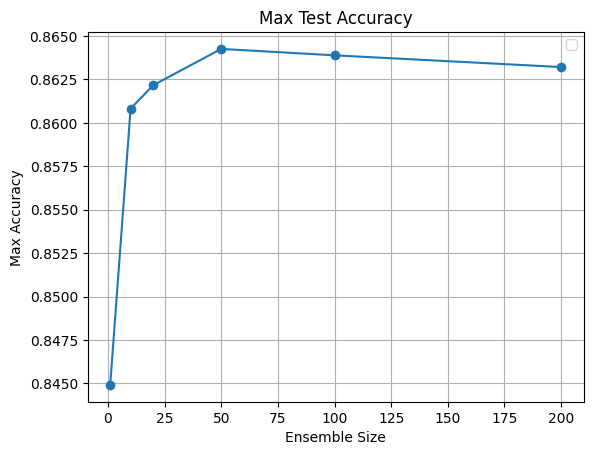

In [10]:
max_test_acc = []
for test_acc in test_acc_list:
    max_test_acc.append(max(test_acc))

plt.plot(ensemble_sizes, max_test_acc, marker='o')
plt.title('Max Test Accuracy')
plt.xlabel('Ensemble Size')
plt.ylabel('Max Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Training Time

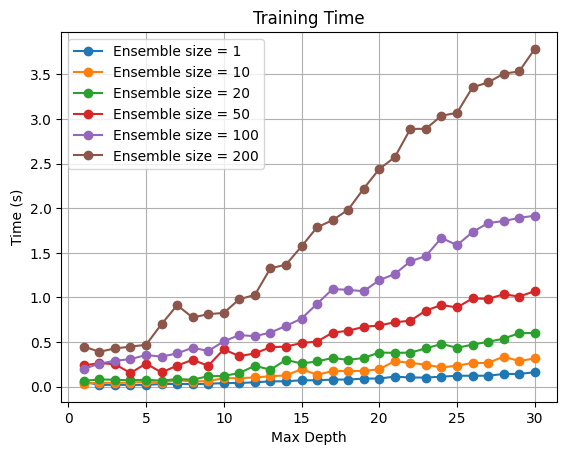

In [11]:
for i, train_time in enumerate(train_time_list):
    plt.plot(range(1, depth_range), train_time, label=f"Ensemble size = {ensemble_sizes[i]}", marker='o')

plt.title('Training Time')
plt.xlabel('Max Depth')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

Similar to `DecisionTreeClassifier`, the `RandomForestClassifier` model starts to overfit at around a `max_depth` of 10. However, the accuracy curve is noticibly rougher.

### Results Discussion

- **What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?**

> At the ensemble size of 1, the accuracy of random forest model increases more irregularly with increasing maximum depth as compared to that of decision tree model.

> Since only a single decision tree is built using bootstrapped subsets of the data, not all features may have been considered during a split. As maximum depth increases, each successive split draws a new random subset of features. Without averaging the result across multiple trees, the accuracy would vary greatly as maximum depth changes.


- **What happens with the curve for random forests as the ensemble size grows?**

> The curve appears "smoother" with less variation as max_depth increases. As ensemble size increases, each individual tree's prediction contributes *less* to the final decision, and the aggregated prediction (via majority vote or averaging) stabilizes, reducing the effect of high-variance fluctuations caused by outlier data or noise in our training set. This is thus the effect of variance reduction via ensembling, which acts as a kind of *regularizer* in this case.

- **What happens with the best observed test set accuracy as the ensemble size grows?**

> Accuracy increases with ensemble size until it reaches the size of 50, where it gradually decreases due to **overfitting**. Before 50, more trees help reduce variance without significantly increasing overfitting. Here, the forest generalises better as individual tree results get averaged out. Beyond 50 hoever, despite using ensembling here, very deep and complex trees still tend to perfectly fit the training set, learning to "memorise" the noise rather than learning general patterns. The benefit of variance reduction will saturate and the bias introduced by depth-related overfitting will take over, reducing the overall test set accuracy.

- **What happens with the training time as the ensemble size grows?**

> Training time **grows proportionally** with ensemble size, as the tree's number of nodes grows exponentially with depth. More nodes require more computations of the possible splits as well as the gini impurity measure, and thus take a longer time to train. 

# Task 3: Feature importances in random forest classifiers

In [ ]:
pipeline = make_pipeline(
    DictVectorizer(), 
    RandomForestClassifier(
        max_depth=10, 
        n_estimators=50, 
        random_state=69, 
        n_jobs=-1
    )
)
pipeline.fit(dicts_Xtrain, Ytrain)

feature_names = pipeline.steps[0][1].feature_names_
feature_importances = pipeline.steps[1][1].feature_importances_

importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns = [1, 2]).explode(2).reset_index(drop = True).add_prefix("column")
importance_df.rename(columns = {"column1": "Feature Name", "column2": "Feature Importance"}, inplace = True)
importance_df = importance_df.sort_values(by="Feature Importance", ascending = False).reset_index(drop=True)

importance_df.head()


,Feature Name,Feature Importance
0,capital-gain,0.179677
1,relationship=Husband,0.133732
2,marital-status=Married-civ-spouse,0.108023
3,education-num,0.101339
4,age,0.071460


### Feature Importance Plot

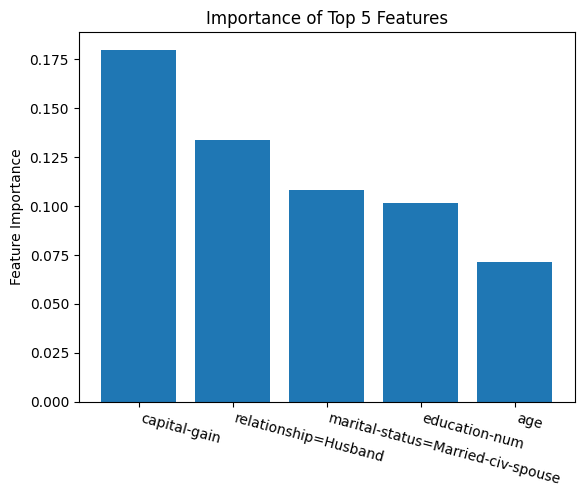

In [13]:
plt.bar(importance_df.head(5)['Feature Name'], importance_df.head(5)['Feature Importance'])
plt.title('Importance of Top 5 Features')
plt.ylabel('Feature Importance')
plt.xticks(rotation = -15, horizontalalignment='left')
plt.show()

The graph above shows the top 5 features with the highest importance score.
> **capital-gain**

- Refers to the profits earned on the sale of an asset.
- Higher capital-gain, would therefore have a direct efffect in raisng one's income.

> **relationship=Husband**

- On average, men are likely to have a higher income than women.
- Married men are also likely to have a higher income than their unmarried counterparts since it suggests that they have the financial means to support a family.

> **marital-status=Married-civ-spouse**

- As explained above, a married participant is likely to have a higher income.
- However, a higher income due to having a civilian spouse could be a result of more entries with civilian spouses in the dataset.


> **education-num**

- In general, a higher education level would lead to more opportunities to land a higher paying job, as education heavily influences a person's job and their income due to educational requirements in the hiring process.

> **age**

- A higher age generally suggests a higher education level and more work experience, which tends to result in higher paying jobs.

### Alternative Importance Score

An alternative method to calculate importance can be **permutation importance**.

It measures the feature'*s impact on the model performance after the model has been trained* through breaking the feature's relationship with the target and measures the drop in performace. A more significant reduction in accuracy implies a greater importance of a feature.